In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, roc_curve, auc
import time
import seaborn as sns


In [2]:
data = loadmat('./datasets/musk.mat')
X = np.array(data.get('X'))
y = np.array(data.get('y')).ravel().astype(int)

In [3]:
print(f"Zbiór danych musk: {X.shape[0]} próbek, {X.shape[1]} cech, {np.sum(y)} anomalii ({100 * np.mean(y):.2f}% outlierów)")
all_results = []


Zbiór danych musk: 3062 próbek, 166 cech, 97 anomalii (3.17% outlierów)



=== Local Outlier Factor (LOF) ===

LOF (n_neighbors=5, contamination=0.01):
Macierz pomyłek:
 [[2945   20]
 [  86   11]]
AUC: 0.4524
Czas wykonania: 0.2009 s

LOF (n_neighbors=5, contamination=0.05):
Macierz pomyłek:
 [[2830  135]
 [  78   19]]
AUC: 0.4524
Czas wykonania: 0.0250 s

LOF (n_neighbors=5, contamination=0.1):
Macierz pomyłek:
 [[2685  280]
 [  70   27]]
AUC: 0.4524
Czas wykonania: 0.0283 s

LOF (n_neighbors=10, contamination=0.01):
Macierz pomyłek:
 [[2936   29]
 [  95    2]]
AUC: 0.6083
Czas wykonania: 0.0307 s

LOF (n_neighbors=10, contamination=0.05):
Macierz pomyłek:
 [[2813  152]
 [  95    2]]
AUC: 0.6083
Czas wykonania: 0.0360 s

LOF (n_neighbors=10, contamination=0.1):
Macierz pomyłek:
 [[2669  296]
 [  86   11]]
AUC: 0.6083
Czas wykonania: 0.0321 s

LOF (n_neighbors=20, contamination=0.01):
Macierz pomyłek:
 [[2934   31]
 [  97    0]]
AUC: 0.5843
Czas wykonania: 0.0371 s

LOF (n_neighbors=20, contamination=0.05):
Macierz pomyłek:
 [[2814  151]
 [  94    3]]
AUC: 0

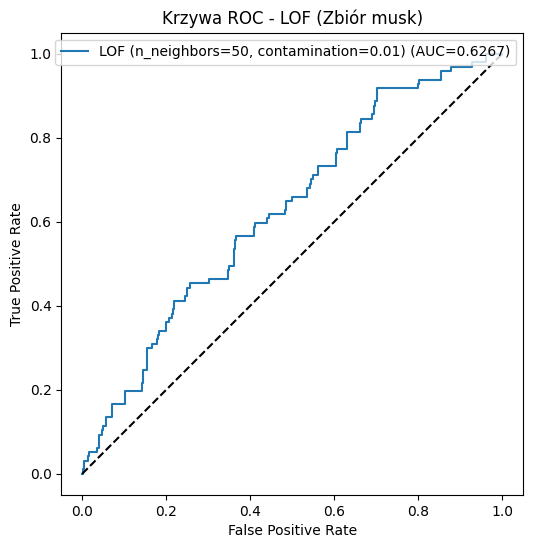

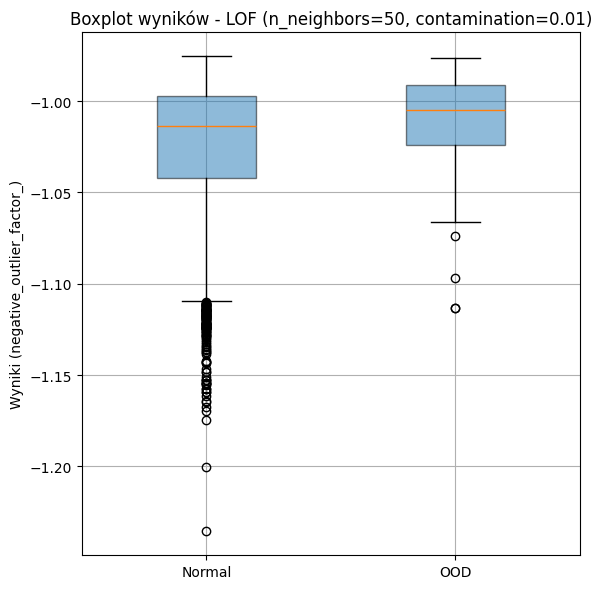

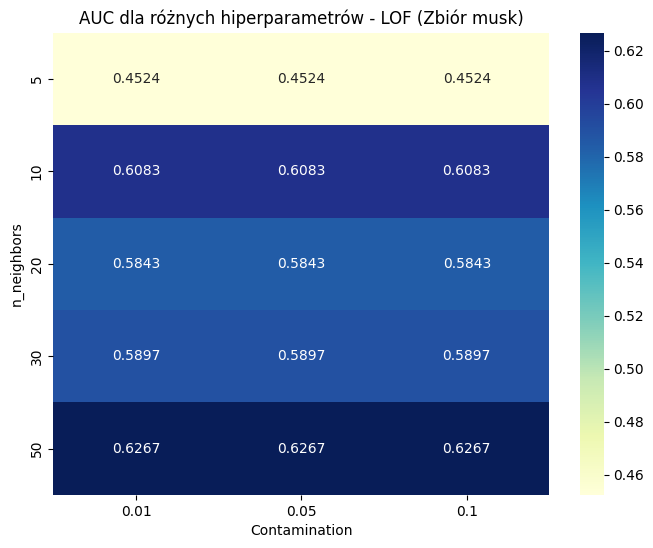

In [4]:
# 1. LOF
print("\n=== Local Outlier Factor (LOF) ===")
n_neighbors_list = [5, 10, 20, 30, 50]
contamination_list = [0.01, 0.05, 0.1]
lof_results = []

for n_neighbors in n_neighbors_list:
    for contamination in contamination_list:
        start_time = time.time()

        model_name = f"LOF (n_neighbors={n_neighbors}, contamination={contamination})"
        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, novelty=False)

        y_pred = lof.fit_predict(X)
        y_pred = np.where(y_pred == 1, 0, 1)

        scores = lof.negative_outlier_factor_
        normal_scores = scores[y == 0]
        ood_scores = scores[y == 1]

        cm = confusion_matrix(y, y_pred)

        fpr, tpr, _ = roc_curve(y, scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        exec_time = time.time() - start_time

        print(f"\n{model_name}:")
        print("Macierz pomyłek:\n", cm)
        print(f"AUC: {roc_auc:.4f}")
        print(f"Czas wykonania: {exec_time:.4f} s")

        lof_results.append({
            'model_name': model_name,
            'y_pred': y_pred,
            'scores': scores,
            'normal_scores': normal_scores,
            'ood_scores': ood_scores,
            'cm': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'exec_time': exec_time,
            'n_neighbors': n_neighbors,
            'contamination': contamination
        })
        all_results.append({
            'Model': model_name,
            'AUC': roc_auc,
            'Czas wykonania (s)': exec_time,
            'TP': cm[1, 1],
            'FP': cm[0, 1],
            'FN': cm[1, 0],
            'TN': cm[0, 0]
        })


best_lof = max(lof_results, key=lambda x: x['roc_auc'])

# Wykres ROC dla najlepszego LOF
plt.figure(figsize=(6, 6))
plt.plot(best_lof['fpr'], best_lof['tpr'], label=f"{best_lof['model_name']} (AUC={best_lof['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - LOF (Zbiór musk)')
plt.legend()
plt.axis('square')
plt.show()

# Boxplot dla najlepszego LOF
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([best_lof['normal_scores'], best_lof['ood_scores']], 
           positions=[1, 2], widths=0.4, patch_artist=True,
           boxprops=dict(facecolor='C0', alpha=0.5))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal', 'OOD'])
ax.set_title(f'Boxplot wyników - {best_lof["model_name"]}')
ax.set_ylabel('Wyniki (negative_outlier_factor_)')
ax.grid()
plt.tight_layout()
plt.show()

# Heatmapa AUC dla różnych hiperparametrów LOF
auc_matrix = np.zeros((len(n_neighbors_list), len(contamination_list)))
for result in lof_results:
    i = n_neighbors_list.index(result['n_neighbors'])
    j = contamination_list.index(result['contamination'])
    auc_matrix[i, j] = result['roc_auc']
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.4f', xticklabels=contamination_list, yticklabels=n_neighbors_list, cmap='YlGnBu')
plt.xlabel('Contamination')
plt.ylabel('n_neighbors')
plt.title('AUC dla różnych hiperparametrów - LOF (Zbiór musk)')
plt.show()


=== Isolation Forest ===

Isolation Forest (n_estimators=50, contamination=0.01):
Macierz pomyłek:
 [[2965    0]
 [  66   31]]
AUC: 0.9933
Czas wykonania: 0.0831 s

Isolation Forest (n_estimators=50, contamination=0.05):
Macierz pomyłek:
 [[2898   67]
 [  10   87]]
AUC: 0.9933
Czas wykonania: 0.0798 s

Isolation Forest (n_estimators=50, contamination=0.1):
Macierz pomyłek:
 [[2753  212]
 [   2   95]]
AUC: 0.9933
Czas wykonania: 0.0843 s

Isolation Forest (n_estimators=100, contamination=0.01):
Macierz pomyłek:
 [[2965    0]
 [  66   31]]
AUC: 0.9999
Czas wykonania: 0.1598 s

Isolation Forest (n_estimators=100, contamination=0.05):
Macierz pomyłek:
 [[2908   57]
 [   0   97]]
AUC: 0.9999
Czas wykonania: 0.1608 s

Isolation Forest (n_estimators=100, contamination=0.1):
Macierz pomyłek:
 [[2755  210]
 [   0   97]]
AUC: 0.9999
Czas wykonania: 0.1652 s

Isolation Forest (n_estimators=200, contamination=0.01):
Macierz pomyłek:
 [[2965    0]
 [  66   31]]
AUC: 1.0000
Czas wykonania: 0.3200 s

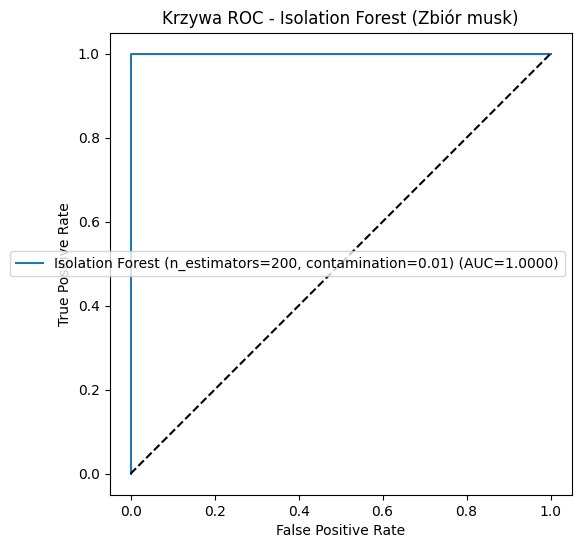

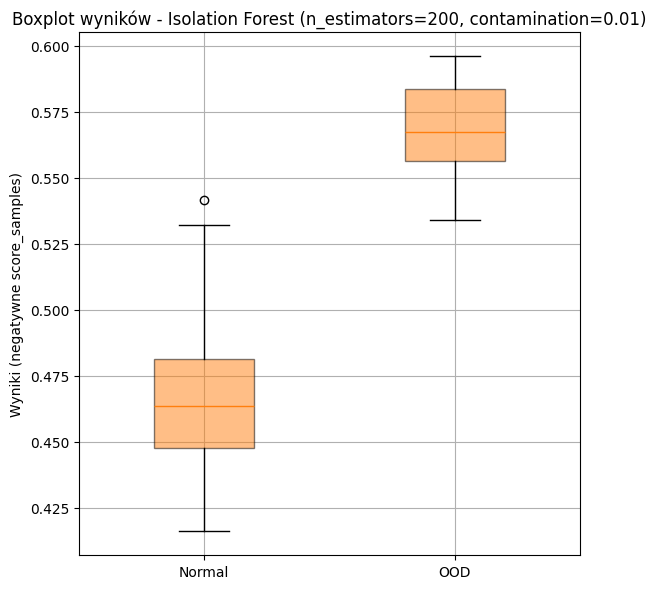

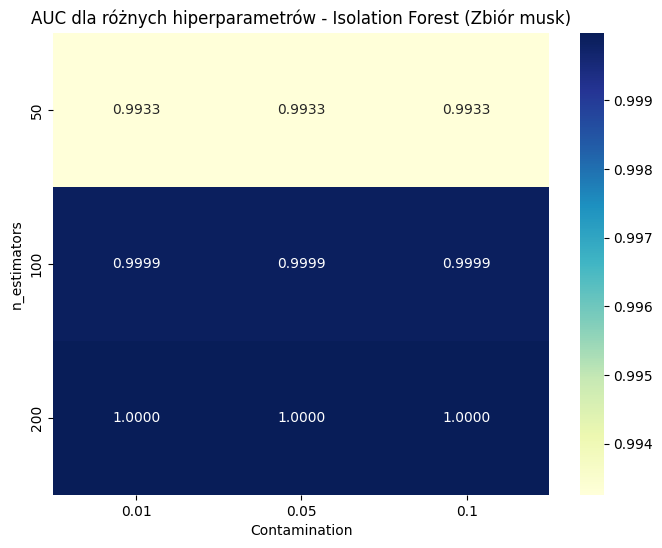

In [5]:
# 2. Isolation Forest
print("\n=== Isolation Forest ===")
n_estimators_list = [50, 100, 200]
contamination_list = [0.01, 0.05, 0.1]
iso_results = []

for n_estimators in n_estimators_list:
    for contamination in contamination_list:
        start_time = time.time()

        model_name = f"Isolation Forest (n_estimators={n_estimators}, contamination={contamination})"
        iso_forest = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)

        y_pred = iso_forest.fit_predict(X)
        y_pred = np.where(y_pred == 1, 0, 1)

        scores = -iso_forest.score_samples(X)
        normal_scores = scores[y == 0]
        ood_scores = scores[y == 1]

        cm = confusion_matrix(y, y_pred)

        fpr, tpr, _ = roc_curve(y, scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        exec_time = time.time() - start_time

        print(f"\n{model_name}:")
        print("Macierz pomyłek:\n", cm)
        print(f"AUC: {roc_auc:.4f}")
        print(f"Czas wykonania: {exec_time:.4f} s")

        iso_results.append({
            'model_name': model_name,
            'y_pred': y_pred,
            'scores': scores,
            'normal_scores': normal_scores,
            'ood_scores': ood_scores,
            'cm': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'exec_time': exec_time,
            'n_estimators': n_estimators,
            'contamination': contamination
        })
        all_results.append({
            'Model': model_name,
            'AUC': roc_auc,
            'Czas wykonania (s)': exec_time,
            'TP': cm[1, 1],
            'FP': cm[0, 1],
            'FN': cm[1, 0],
            'TN': cm[0, 0]
        })


best_iso = max(iso_results, key=lambda x: x['roc_auc'])

# Wykres ROC dla najlepszego Isolation Forest
plt.figure(figsize=(6, 6))
plt.plot(best_iso['fpr'], best_iso['tpr'], label=f"{best_iso['model_name']} (AUC={best_iso['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Isolation Forest (Zbiór musk)')
plt.legend()
plt.axis('square')
plt.show()

# Boxplot dla najlepszego Isolation Forest
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([best_iso['normal_scores'], best_iso['ood_scores']], 
           positions=[1, 2], widths=0.4, patch_artist=True,
           boxprops=dict(facecolor='C1', alpha=0.5))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal', 'OOD'])
ax.set_title(f'Boxplot wyników - {best_iso["model_name"]}')
ax.set_ylabel('Wyniki (negatywne score_samples)')
ax.grid()
plt.tight_layout()
plt.show()

# Heatmapa AUC dla różnych hiperparametrów Isolation Forest
auc_matrix = np.zeros((len(n_estimators_list), len(contamination_list)))
for result in iso_results:
    i = n_estimators_list.index(result['n_estimators'])
    j = contamination_list.index(result['contamination'])
    auc_matrix[i, j] = result['roc_auc']
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.4f', xticklabels=contamination_list, yticklabels=n_estimators_list, cmap='YlGnBu')
plt.xlabel('Contamination')
plt.ylabel('n_estimators')
plt.title('AUC dla różnych hiperparametrów - Isolation Forest (Zbiór musk)')
plt.show()



=== One-Class SVM ===

One-Class SVM (nu=0.01, gamma=0.001):
Macierz pomyłek:
 [[1362 1603]
 [  81   16]]
AUC: 0.2150
Czas wykonania: 2.7091 s

One-Class SVM (nu=0.01, gamma=0.01):
Macierz pomyłek:
 [[ 852 2113]
 [  45   52]]
AUC: 0.4608
Czas wykonania: 2.7290 s

One-Class SVM (nu=0.01, gamma=scale):
Macierz pomyłek:
 [[2914   51]
 [  86   11]]
AUC: 0.7779
Czas wykonania: 0.0970 s

One-Class SVM (nu=0.05, gamma=0.001):
Macierz pomyłek:
 [[1222 1743]
 [  76   21]]
AUC: 0.3048
Czas wykonania: 2.7100 s

One-Class SVM (nu=0.05, gamma=0.01):
Macierz pomyłek:
 [[2074  891]
 [  53   44]]
AUC: 0.5181
Czas wykonania: 2.6998 s

One-Class SVM (nu=0.05, gamma=scale):
Macierz pomyłek:
 [[2840  125]
 [  64   33]]
AUC: 0.8064
Czas wykonania: 0.1766 s

One-Class SVM (nu=0.1, gamma=0.001):
Macierz pomyłek:
 [[1129 1836]
 [  64   33]]
AUC: 0.3071
Czas wykonania: 2.7729 s

One-Class SVM (nu=0.1, gamma=0.01):
Macierz pomyłek:
 [[1293 1672]
 [  29   68]]
AUC: 0.6114
Czas wykonania: 2.9393 s

One-Class SVM

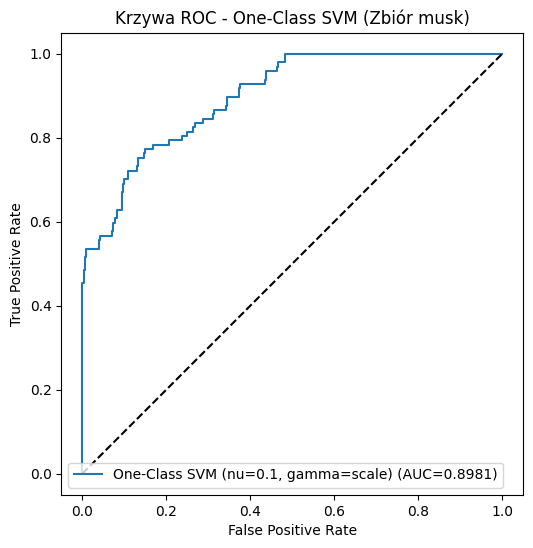

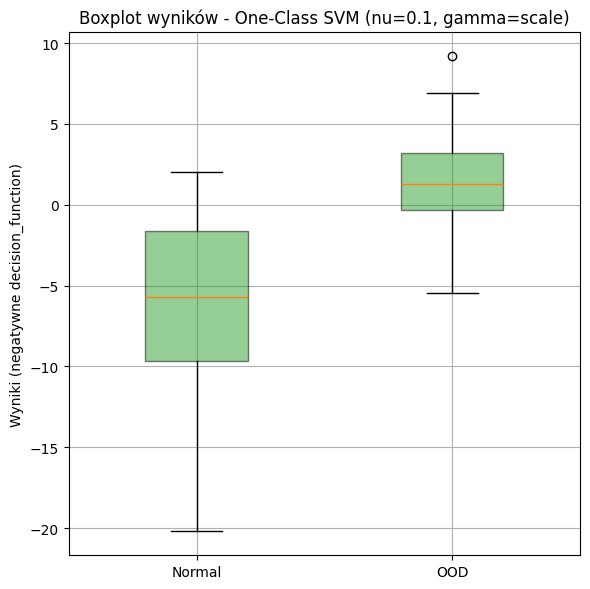

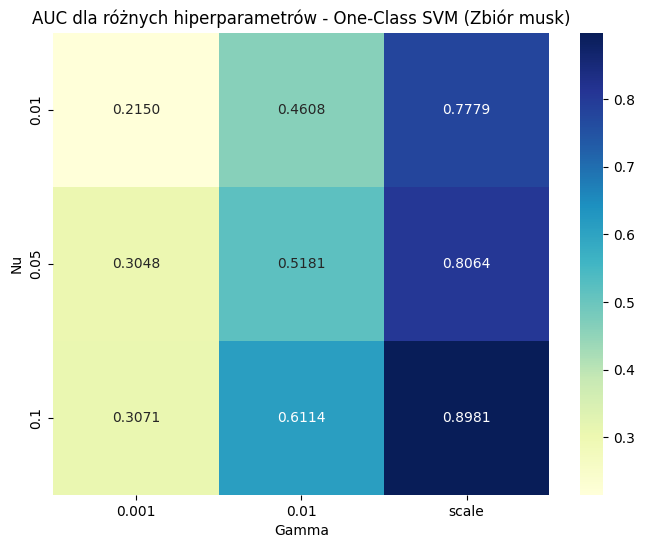

In [6]:
# 3. One-Class SVM
print("\n=== One-Class SVM ===")
nu_list = [0.01, 0.05, 0.1]
gamma_list = [0.001, 0.01, 'scale']
svm_results = []

for nu in nu_list:
    for gamma in gamma_list:
        start_time = time.time()

        model_name = f"One-Class SVM (nu={nu}, gamma={gamma})"
        ocsvm = OneClassSVM(nu=nu, gamma=gamma, kernel='rbf')

        y_pred = ocsvm.fit_predict(X)
        y_pred = np.where(y_pred == 1, 0, 1)

        scores = -ocsvm.decision_function(X)
        normal_scores = scores[y == 0]
        ood_scores = scores[y == 1]

        cm = confusion_matrix(y, y_pred)

        fpr, tpr, _ = roc_curve(y, scores, pos_label=1)
        roc_auc = auc(fpr, tpr)
        exec_time = time.time() - start_time

        print(f"\n{model_name}:")
        print("Macierz pomyłek:\n", cm)
        print(f"AUC: {roc_auc:.4f}")
        print(f"Czas wykonania: {exec_time:.4f} s")

        svm_results.append({
            'model_name': model_name,
            'y_pred': y_pred,
            'scores': scores,
            'normal_scores': normal_scores,
            'ood_scores': ood_scores,
            'cm': cm,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'exec_time': exec_time,
            'nu': nu,
            'gamma': gamma
        })
        all_results.append({
            'Model': model_name,
            'AUC': roc_auc,
            'Czas wykonania (s)': exec_time,
            'TP': cm[1, 1],
            'FP': cm[0, 1],
            'FN': cm[1, 0],
            'TN': cm[0, 0]
        })


best_svm = max(svm_results, key=lambda x: x['roc_auc'])

# Wykres ROC dla najlepszego One-Class SVM
plt.figure(figsize=(6, 6))
plt.plot(best_svm['fpr'], best_svm['tpr'], label=f"{best_svm['model_name']} (AUC={best_svm['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - One-Class SVM (Zbiór musk)')
plt.legend()
plt.axis('square')
plt.show()

# Boxplot dla najlepszego One-Class SVM
fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([best_svm['normal_scores'], best_svm['ood_scores']], 
           positions=[1, 2], widths=0.4, patch_artist=True,
           boxprops=dict(facecolor='C2', alpha=0.5))
ax.set_xticks([1, 2])
ax.set_xticklabels(['Normal', 'OOD'])
ax.set_title(f'Boxplot wyników - {best_svm["model_name"]}')
ax.set_ylabel('Wyniki (negatywne decision_function)')
ax.grid()
plt.tight_layout()
plt.show()

# Heatmapa AUC dla różnych hiperparametrów One-Class SVM
auc_matrix = np.zeros((len(nu_list), len(gamma_list)))
for result in svm_results:
    i = nu_list.index(result['nu'])
    j = gamma_list.index(result['gamma'])
    auc_matrix[i, j] = result['roc_auc']
plt.figure(figsize=(8, 6))
sns.heatmap(auc_matrix, annot=True, fmt='.4f', xticklabels=gamma_list, yticklabels=nu_list, cmap='YlGnBu')
plt.xlabel('Gamma')
plt.ylabel('Nu')
plt.title('AUC dla różnych hiperparametrów - One-Class SVM (Zbiór musk)')
plt.show()

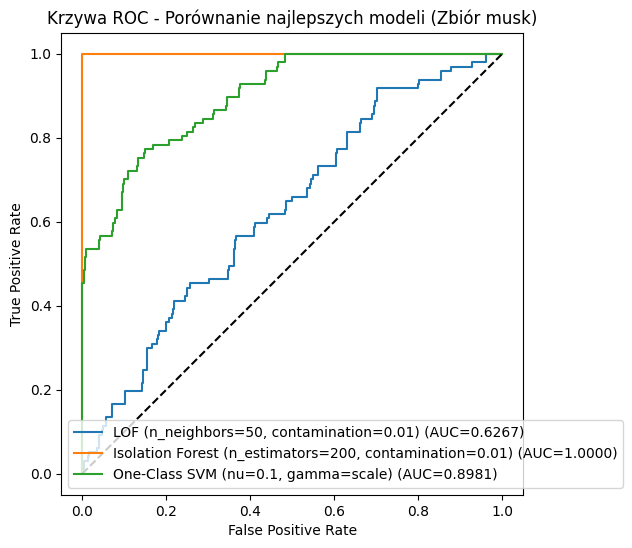


Podsumowanie wyników:
                                                Model       AUC  \
0             LOF (n_neighbors=5, contamination=0.01)  0.452405   
1             LOF (n_neighbors=5, contamination=0.05)  0.452405   
2              LOF (n_neighbors=5, contamination=0.1)  0.452405   
3            LOF (n_neighbors=10, contamination=0.01)  0.608310   
4            LOF (n_neighbors=10, contamination=0.05)  0.608310   
5             LOF (n_neighbors=10, contamination=0.1)  0.608310   
6            LOF (n_neighbors=20, contamination=0.01)  0.584305   
7            LOF (n_neighbors=20, contamination=0.05)  0.584305   
8             LOF (n_neighbors=20, contamination=0.1)  0.584305   
9            LOF (n_neighbors=30, contamination=0.01)  0.589719   
10           LOF (n_neighbors=30, contamination=0.05)  0.589719   
11            LOF (n_neighbors=30, contamination=0.1)  0.589719   
12           LOF (n_neighbors=50, contamination=0.01)  0.626710   
13           LOF (n_neighbors=50, conta

In [7]:
# Porównawczy wykres ROC dla wszystkich najlepszych modeli
plt.figure(figsize=(8, 6))
plt.plot(best_lof['fpr'], best_lof['tpr'], label=f"{best_lof['model_name']} (AUC={best_lof['roc_auc']:.4f})")
plt.plot(best_iso['fpr'], best_iso['tpr'], label=f"{best_iso['model_name']} (AUC={best_iso['roc_auc']:.4f})")
plt.plot(best_svm['fpr'], best_svm['tpr'], label=f"{best_svm['model_name']} (AUC={best_svm['roc_auc']:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC - Porównanie najlepszych modeli (Zbiór musk)')
plt.legend()
plt.axis('square')
plt.show()

# Zapis wyników do DataFrame
results_df = pd.DataFrame(all_results)
print("\nPodsumowanie wyników:")
print(results_df)